In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## 🏃🏻 `Fastkaggle` 
### Paddy Doctor: Paddy Disease Classification
Ref: https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3

In [2]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
from fastai.vision.all import *
set_seed(42)

### Looking at the data

(480, 640)


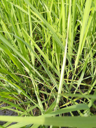

In [28]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

### Check image size
The first image is 480x640 – we can check the rest of them using `fastcore` parallel.

In [5]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


(480, 640)    10403
(640, 480)        4
dtype: int64

In [6]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [7]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


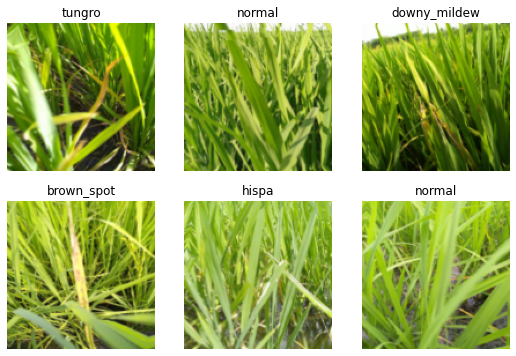

In [8]:
dls.show_batch(max_n=6)

In [41]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, metrics=error_rate, n_out=10).to_fp16()
lr = 0.01

In [22]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.207155,0.820968,0.259491,01:54


epoch,train_loss,valid_loss,error_rate,time
0,0.596304,0.367553,0.120615,02:09


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


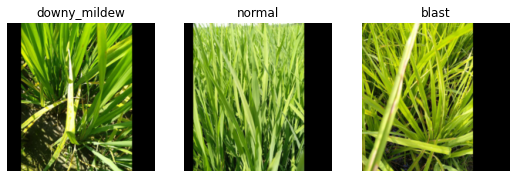

In [46]:
# Different attempt

dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))

dls.show_batch(max_n=3)

In [ ]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [ ]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,1.229734,0.780589,0.256127,01:52


epoch,train_loss,valid_loss,error_rate,time
0,0.619369,0.429166,0.130226,02:05
1,0.490674,0.310957,0.106679,02:09
2,0.325558,0.188043,0.059587,02:09
3,0.192680,0.138895,0.039885,02:10


#### Test time augmentation

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

With error rate:

In [ ]:
error_rate(tta_preds, targs)

## Using sub-category for development
* `bacterial_panicle_blight`

In [9]:
df = pd.read_csv(path/'train.csv')
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [10]:
trn_path = path/'train_images'/'bacterial_panicle_blight'

In [11]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
        
import gc
def report_gpu():
    # function to find out how much memory is used
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
train('convnext_small_in22k', 128, epochs=1, accum=1, finetune=False)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:05


In [18]:
Resize(480, method='squish')

Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 

paddy-disease-classification\train_images\blast\105920.jpg
(480, 640)


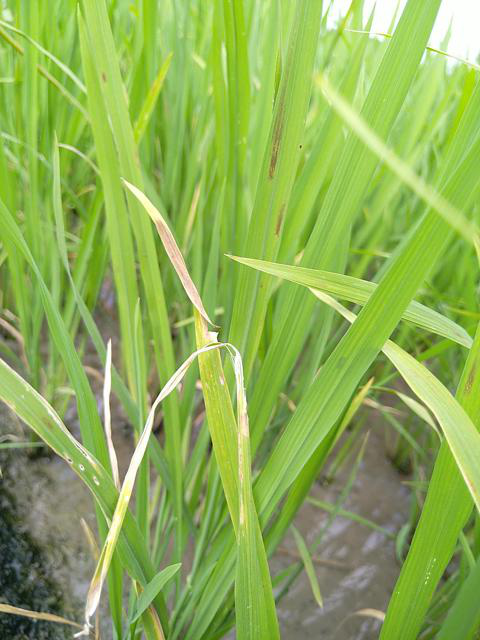

In [37]:
files = get_image_files(path/'train_images')

img = PILImage.create(files[2202])
print(files[2202])
print(img.size)

img

paddy-disease-classification\train_images\blast\105925.jpg
(480, 640)


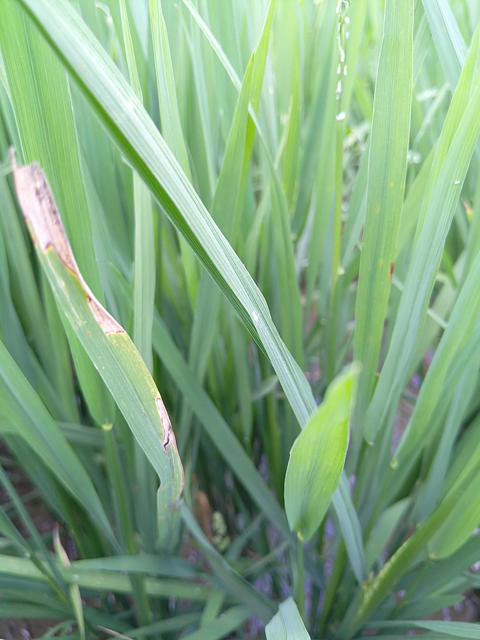

In [38]:
img = PILImage.create(files[2203])
print(files[2203])
print(img.size)

img